# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [1]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function.

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [0]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)


    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))


    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        image_rec= self.decoder(z)
        return image_rec, mu, log_var


## Loss function

In [0]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()


optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    RecLoss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLDLoss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return RecLoss + KLDLoss


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [0]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [0]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples. 

In [0]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = vae.decoder(z).cuda()
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')



## Main loop

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 545.657461
Train Epoch: 1 [10000/60000 (17%)]	Loss: 180.062363
Train Epoch: 1 [20000/60000 (33%)]	Loss: 176.190664
Train Epoch: 1 [30000/60000 (50%)]	Loss: 168.046543
Train Epoch: 1 [40000/60000 (67%)]	Loss: 164.285820
Train Epoch: 1 [50000/60000 (83%)]	Loss: 165.122207
====> Epoch: 1 Average loss: 178.1602
====> Test set loss: 162.0538
(64, 1, 28, 28)


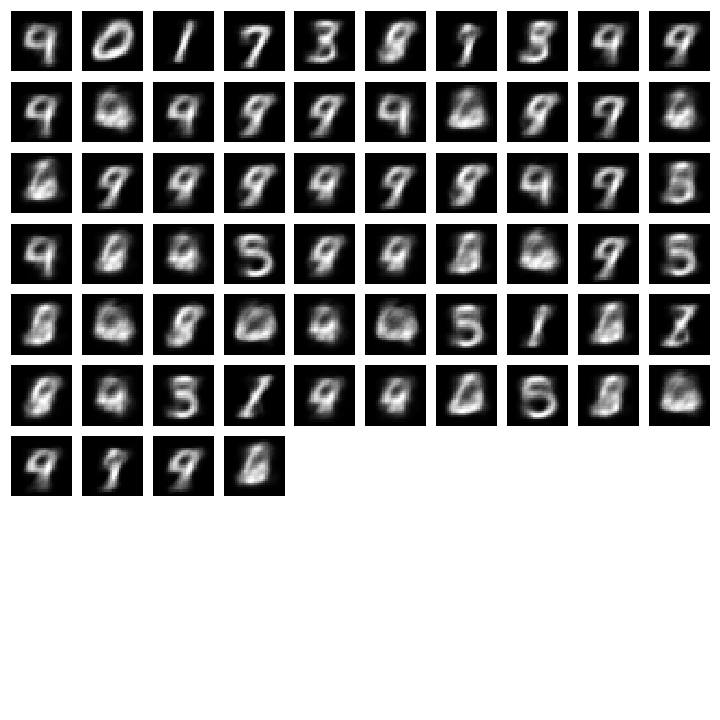

Train Epoch: 2 [0/60000 (0%)]	Loss: 164.927695
Train Epoch: 2 [10000/60000 (17%)]	Loss: 164.527656
Train Epoch: 2 [20000/60000 (33%)]	Loss: 167.458574
Train Epoch: 2 [30000/60000 (50%)]	Loss: 153.787080
Train Epoch: 2 [40000/60000 (67%)]	Loss: 155.553926
Train Epoch: 2 [50000/60000 (83%)]	Loss: 158.183457
====> Epoch: 2 Average loss: 158.0602
====> Test set loss: 154.6621
(64, 1, 28, 28)


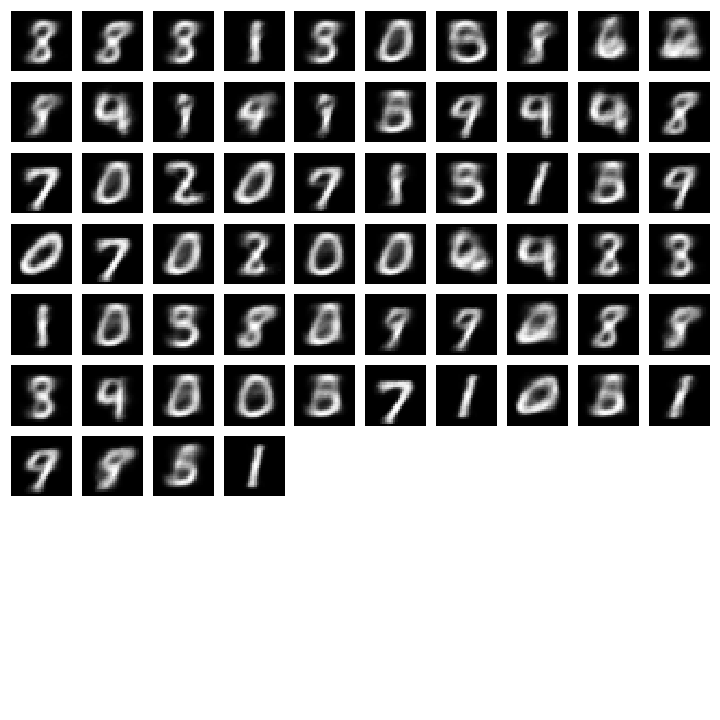

Train Epoch: 3 [0/60000 (0%)]	Loss: 155.974541
Train Epoch: 3 [10000/60000 (17%)]	Loss: 152.835088
Train Epoch: 3 [20000/60000 (33%)]	Loss: 153.698350
Train Epoch: 3 [30000/60000 (50%)]	Loss: 155.456729
Train Epoch: 3 [40000/60000 (67%)]	Loss: 153.038730
Train Epoch: 3 [50000/60000 (83%)]	Loss: 147.367949
====> Epoch: 3 Average loss: 152.5464
====> Test set loss: 151.1911
(64, 1, 28, 28)


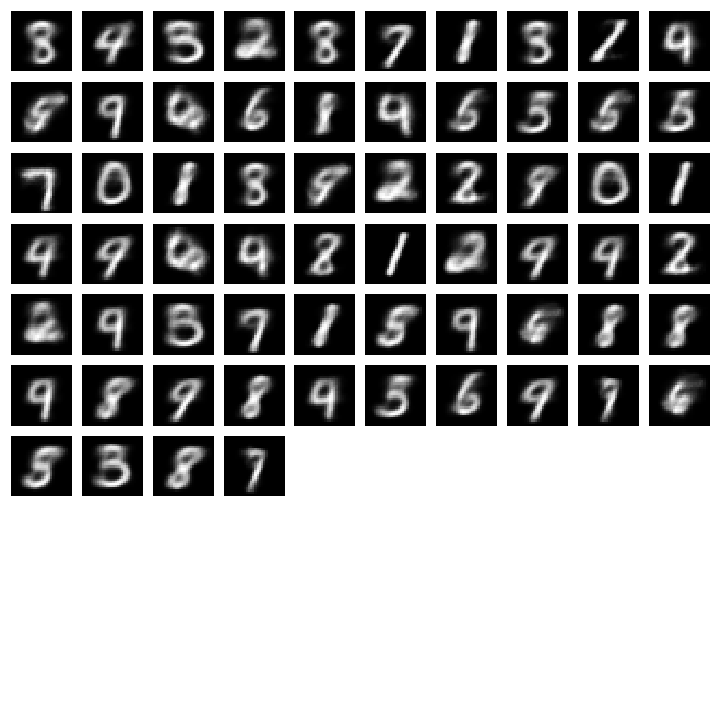

Train Epoch: 4 [0/60000 (0%)]	Loss: 143.432129
Train Epoch: 4 [10000/60000 (17%)]	Loss: 142.115547
Train Epoch: 4 [20000/60000 (33%)]	Loss: 156.481289
Train Epoch: 4 [30000/60000 (50%)]	Loss: 158.790820
Train Epoch: 4 [40000/60000 (67%)]	Loss: 147.023477
Train Epoch: 4 [50000/60000 (83%)]	Loss: 160.663750
====> Epoch: 4 Average loss: 149.3909
====> Test set loss: 147.9821
(64, 1, 28, 28)


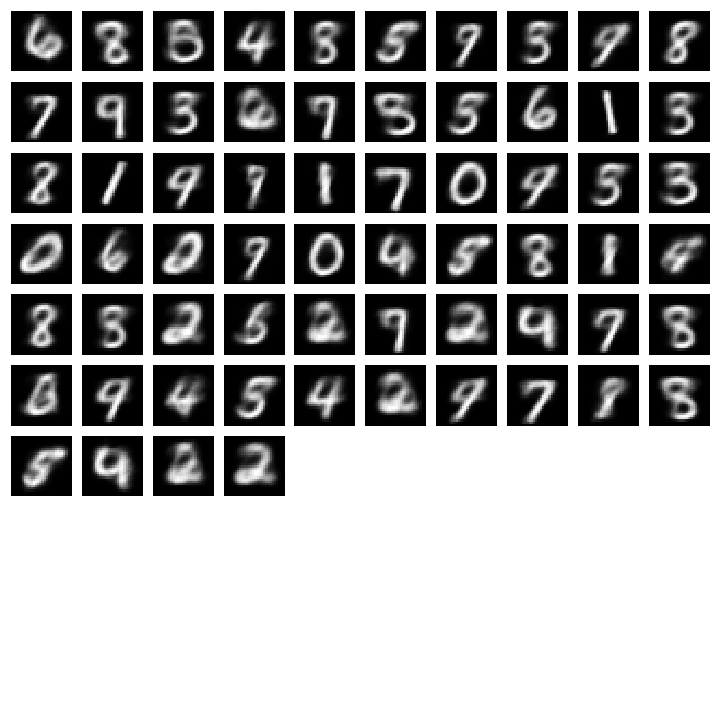

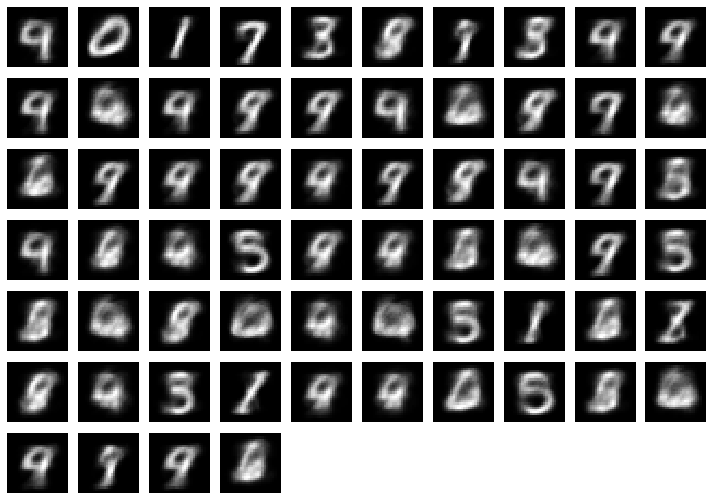

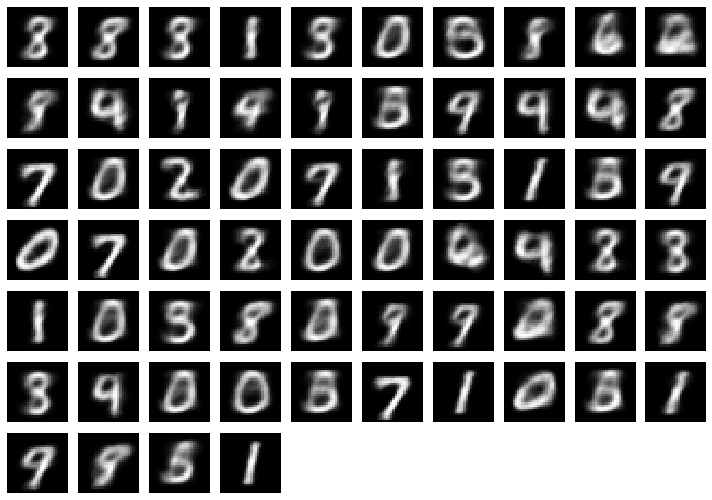

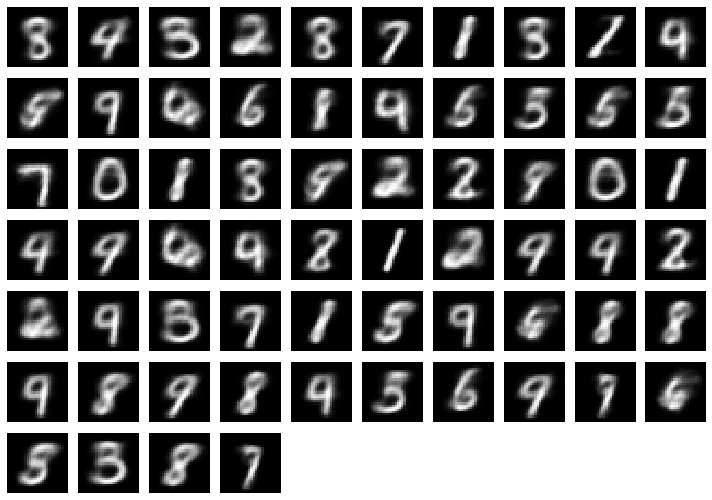

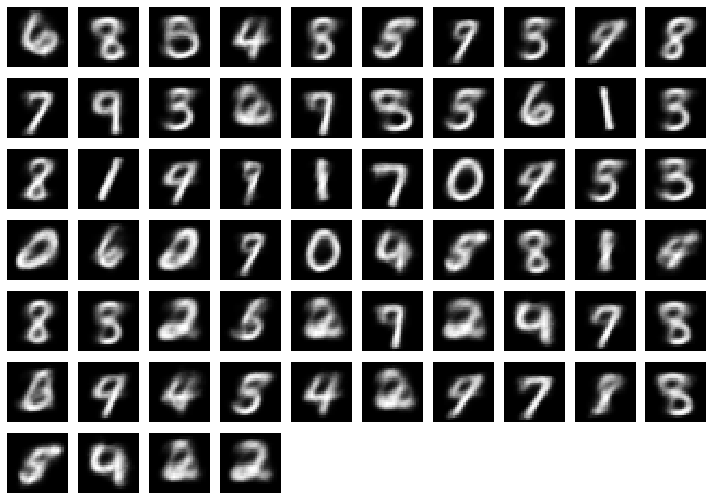

In [7]:

for epoch in range(1, 5):
    train(epoch)
    test()
    

## Interpolation
Sample two latent vectors and generate images by performing linear interpolation.

(1, 1, 28, 28)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


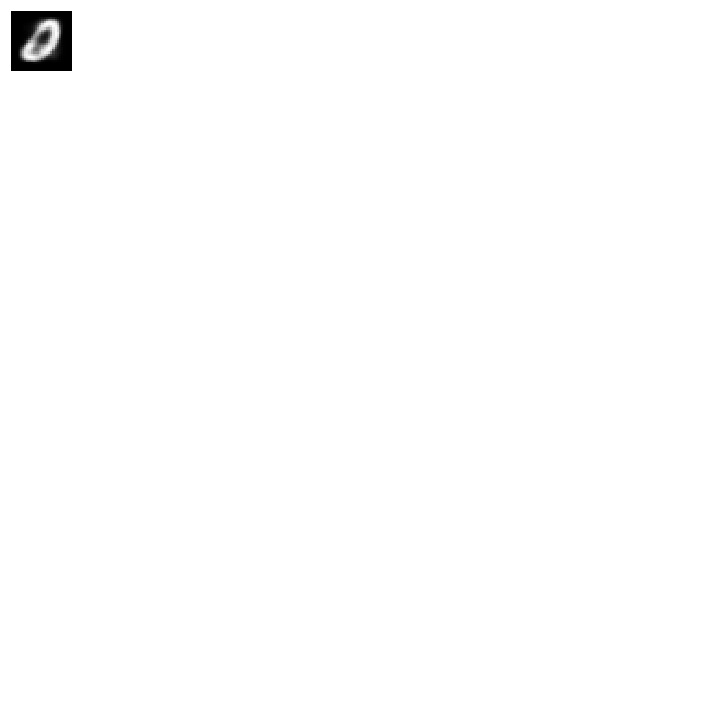

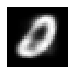

In [9]:
with torch.no_grad():
      z = torch.randn(1, 2).cuda()
      generated = vae.decoder(z).cuda()
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))

## Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe? 


In [0]:
# ...

## Interpolation
Sample two latent vectors and generate images by performing linear interpolation.

In [0]:
# ...


Sample real images from MNIST and flip them to obtain digits that do not exist. What do you observe about their likelihood?

In [0]:
# ...

## Fashion mnist
Change dataset. Replace mnist by fashionMNIST and check how it works.